# Predict Future Sales - Base 5

# 제 1차 해커톤 (대전) : 캐글 축제 [Predict Future Sales]
**사이트 링크 :**https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview


### ● 팀이름 : Vitamin-Team2  [비타민이 부족해 (2조)] 
### ● 팀 원 : 양윤정(yoonjeongYang), 김상민(kkk3449), 임진선(limjs19)
### ● 역할 분담 : 

###       양윤정  : 모델 평가 및 설명, 회의록 작성

###       김상민  : 코드 분석 및 주석, 시각화

###       임진선  : 코드 수정  및 통합, 시각화, 샘플 서치

  **팀 회의록 (노션페이지) : https://www.notion.so/2-1777030018a6434a89e8e60208fff9f1**  

  **화상회의 주소 : https://meet.google.com/bvs-xzzt-hwh**
  

# ♣ 목표

### 러시아 최대 소프트웨어 회사 중 하나 인 1C Company에서 제공하는 일일 판매 데이터로
### 시계열 데이터를 작업하여 `다음 달의 모든 제품 및 매장의 총 판매량을 예측`하는 프로젝트

**파일 설명**  
    • sales_train.csv - 훈련 세트. 2013 년 1 월부터 2015 년 10 월까지의 일일 기록 데이터      
    • test.csv - 테스트 세트 이러한 상점과 제품의 2015 년 11 월 매출을 예측   
    1048575개의 데이터 (약 2년치, 일일 판매량)
    • sample_submission.csv - 올바른 형식의 샘플 제출 파일  
    • items.csv - 항목 / 제품에 대한 추가 정보  
    • item_categories.csv - 항목 카테고리에 대한 추가 정보  
    • shops.csv - 상점에 대한 추가 정보.   
    
**데이터 필드**  
    • ID - 테스트 세트 내에서 (Shop, Item) 튜플을 나타내는 Id  
    • shop_id - 상점의 고유 식별자  
    • item_id - 상품의 고유 식별자  
    • item_category_id - 항목 카테고리의 고유 식별자  
    • item_cnt_day - 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측  
    • item_price - 상품의 현재 가격  
    • date - dd/mm/yyyy 형식의 날짜  
    • date_block_num - 편의를 위해 사용되는 연속 된 월 번호 
      (2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33임)
    • item_name -  항목 이름  
    • shop_name - 상점 이름  
    • item_category_name - 항목 카테고리 이름
    
**데이터 설명**
  * 일일 이력 판매 데이터(실제 데이터 셋)
  * 작업은 테스트 세트에 대해 판매된 제품의 총량을 예측하는 것  
  * 누락되거나 비합리적인 값이있을 수 있음  
  * 잘못된 데이터를 처리하고 좋은 결과 값을 얻기 위한 다양한 모델 학습 시도 필요 

`Train`     	
데이터	: Item x shop x day 	  
기간 : 34 개월  
집계 : 매일   
`Test`  
데이터 : Item x shop
기간 : 1개월   
집계 : 월간   


## Step 0. 패키지 로드

In [1]:
# packages
import numpy as np # 배열 모듈
import pandas as pd # 판다스 모듈

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product #데카르트 곱 사용 메소드
import statsmodels.api as sm # 시계열 데이터 계절적 성분 분리 모듈

from sklearn.preprocessing import LabelEncoder #문자를 숫자(수치화), 숫자를 문자로 매핑하는 모듈

import seaborn as sns # 시계열 데이터 그래프 출력 모듈 -펀더멘탈 8-10
import matplotlib.pyplot as plt # 그래프 출력 모듈
%matplotlib inline

from xgboost import XGBRegressor # XGBoost 모듈 
from xgboost import plot_importance # XGBoost 모듈 

def plot_features(booster, figsize): #중요변수 시각화 함수    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time # 코드 돌아가는 시간 체크 모듈
import sys # python interpreter 와 관련된 정보와 기능을 제공 파이썬 버젼 확인용
import gc # 메모리 관리 모듈
import pickle # 전처리한 데이터 저장하는 모듈
sys.version_info #파이썬 버젼 확인용

sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

## Step 1. 데이터 불러오기
* os 모듈로 path를 설정하고 pandas.read_csv()함수로 csv 파일을 읽는다.

In [2]:
# import datasets
import os 

PATH = os.getenv('HOME')+'/aiffel/hakerton1'
sample_sub = pd.read_csv(PATH+'sample_submission.csv')

items = pd.read_csv(PATH+'items.csv')
shops = pd.read_csv(PATH+'shops.csv')
cats = pd.read_csv(PATH+'item_categories.csv')
train = pd.read_csv(PATH+'sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv(PATH+'test.csv').set_index('ID')

## Step 2. 데이터 확인

In [3]:
# 데이터 형태 확인 
print("Shape of train:", train.shape)
print("Shape of test:", test.shape)
print("Shape of shops:", shops.shape)
print("Shape of items:", items.shape)
print("Shape of item_categories:", cats.shape)

Shape of train: (2935849, 6)
Shape of test: (214200, 2)
Shape of shops: (60, 2)
Shape of items: (22170, 3)
Shape of item_categories: (84, 2)


In [4]:
train.head()
#train.count()     #데이터 건수 확인

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
train.loc[:,'date'] = pd.to_datetime(train.date)

In [6]:
# 데이터의 정합성을 확인합니다
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
#날짜형으로 바뀐 date 확인
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [8]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [9]:
shops.sample(10)
#러시아어로 된 상점 이름 

,shop_name,shop_id
11,Жуковский ул. Чкалова 39м²,11
29,"Москва ТЦ ""Новый век"" (Новокосино)",29
15,"Калуга ТРЦ ""XXI век""",15
12,Интернет-магазин ЧС,12
35,"Н.Новгород ТРЦ ""Фантастика""",35
9,Выездная Торговля,9
14,"Казань ТЦ ""ПаркХаус"" II",14
25,"Москва ТРК ""Атриум""",25
33,"Мытищи ТРК ""XL-3""",33
48,"Томск ТРЦ ""Изумрудный Город""",48


In [10]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

In [11]:
items.head()
#러시아어로 된 물품명

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
cats.head()
#러시아어로 된 카테고리명
#cats.count()       #갯수 확인

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
#데이터 통계값 확인하기 
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [14]:
train.info()      #데이터 정보 확인 (자료형 확인)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


## Step 3. data 결측치 확인
* isna()와 isnull()은 같은 기능이다

In [15]:
print("No. of Null values in the train set :", train.isnull().sum().sum())
print("No. of Null values in the test set :", test.isnull().sum().sum())
print("No. of Null values in the item set :", items.isnull().sum().sum())
print("No. of Null values in the shops set :", shops.isnull().sum().sum())
print("No. of Null values in the item_categories set :", cats.isnull().sum().sum())

No. of Null values in the train set : 0
No. of Null values in the test set : 0
No. of Null values in the item set : 0
No. of Null values in the shops set : 0
No. of Null values in the item_categories set : 0


### Step3-1. 결측치 확인 결과
* 결측치가 없는것을 확인할 수 있다.

## Step 4. 시각화

### Step 4-1. 84개 카테고리별 물품 수 시각화
* 시계열 데이터 그래프 출력 모듈 sns 사용 - y값 기준이 있는 막대그래프 출력
* pyplot 모듈 사용

#### barplot
* countplot과 모양이 같은 막대그래프이지만, countplot과는 다른 시각화이며, 별개의 툴이다. 가장 큰 차이점은 Y축 값을 설정가능한 점이다.

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


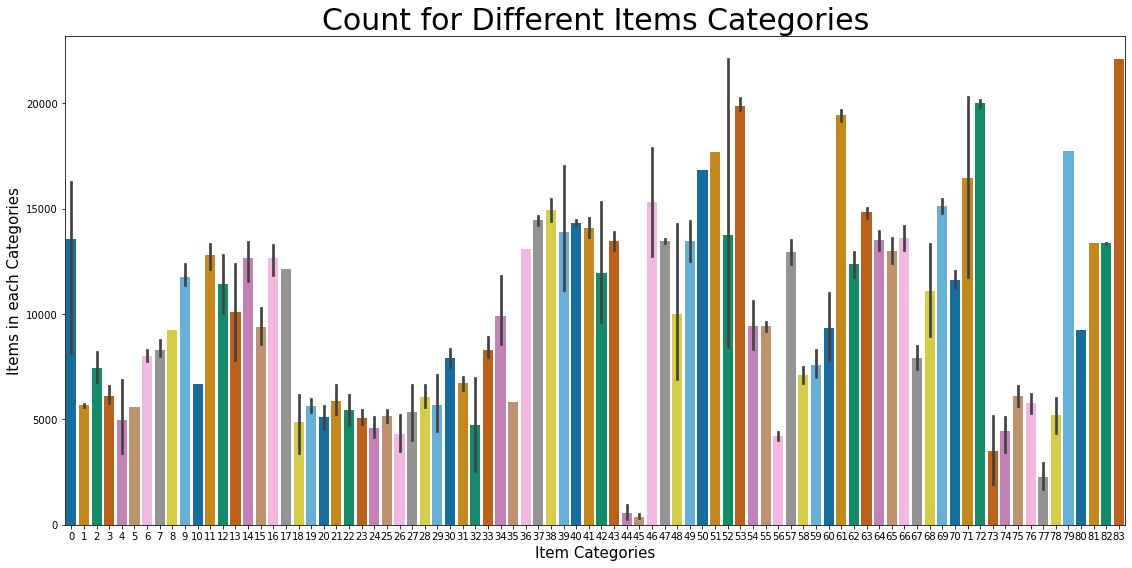

In [16]:
plt.rcParams['figure.figsize'] = (19, 9)
sns.barplot(items['item_category_id'], items['item_id'], palette = 'colorblind')
plt.title('Count for Different Items Categories', fontsize = 30)
plt.xlabel('Item Categories', fontsize = 15)
plt.ylabel('Items in each Categories', fontsize = 15)
plt.show()

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


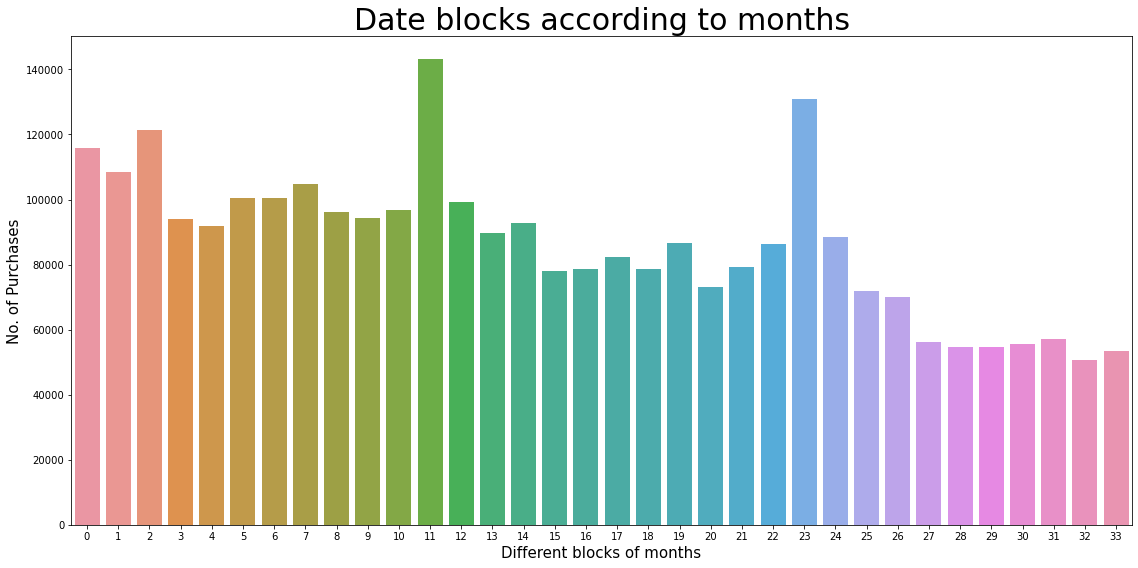

In [17]:
plt.rcParams['figure.figsize'] = (19, 9)
sns.countplot(train['date_block_num'])
plt.title('Date blocks according to months', fontsize = 30)
plt.xlabel('Different blocks of months', fontsize = 15)
plt.ylabel('No. of Purchases', fontsize = 15)
plt.show()

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


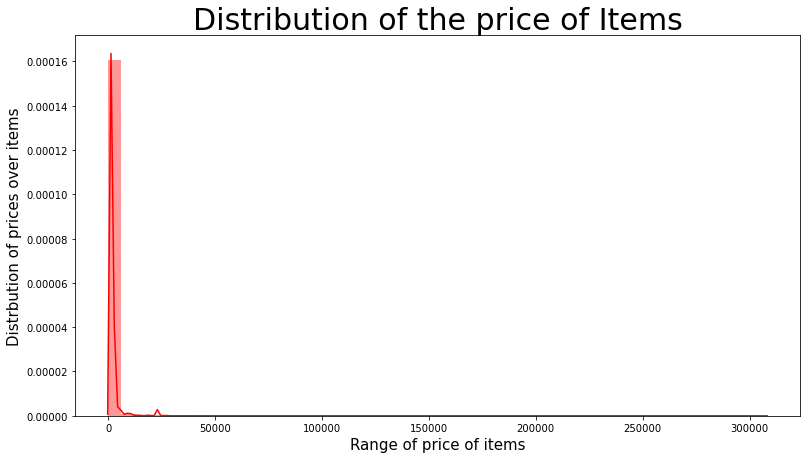

In [18]:
#하루에 판매되는 품목의 분포를 확인
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(train['item_price'], color = 'red')
plt.title('Distribution of the price of Items', fontsize = 30)
plt.xlabel('Range of price of items', fontsize = 15)
plt.ylabel('Distrbution of prices over items', fontsize = 15)
plt.show()

#### 400정도의 가격에서 많은 분포를 띄고있고, 300000이 넘는 가격의 물품도 있다.

### Step 4-4. 물품별 일일 판매 수 확인
* Distribution of the no. of Items Sold per Day - 하루에 판매되는 물품 수
* Range of items sold per day - 하루에 판매되는 물품의 범위
* Distrbutions per day - 일일 분포
* 하루에 가장 많이 팔린 물품 수는 2169이고 0개 팔린 물품의 분포가 가장 많다.

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


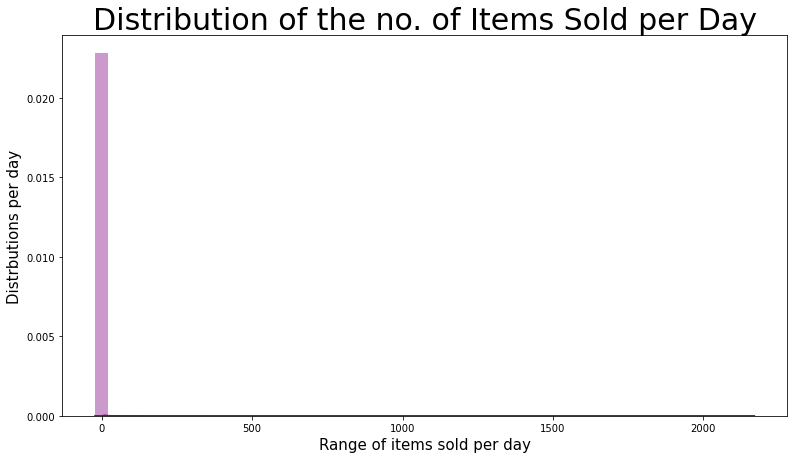

In [19]:
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(train['item_cnt_day'], color = 'purple')
plt.title('Distribution of the no. of Items Sold per Day', fontsize = 30)
plt.xlabel('Range of items sold per day', fontsize = 15)
plt.ylabel('Distrbutions per day', fontsize = 15)
plt.show()

## Step. 5 전처리

### Step 5-1. pandas의 unique() 함수를 써서 dataset에서 유니크한 shop_id와 item_id, tem_category_id를 확인.

In [20]:
# checking the no. of unique item present in the stores
x = train['item_id'].nunique()
print("The No. of Unique Items Present in the stores available: ", x)

# checking the no. of unique item present in the stores
x = cats['item_category_id'].nunique()
print("The No. of Unique categories for Items Present in the stores available: ", x)

# checking the no. of unique shops given in the dataset
x = train['shop_id'].nunique()
print("No. of Unique Shops are :", x)


The No. of Unique Items Present in the stores available:  21807
The No. of Unique categories for Items Present in the stores available:  84
No. of Unique Shops are : 60


### Step 5-2. 일년원일 묶여있는 train.date 항목을 일,년,월,주,일로 분리함.

In [21]:
# making a new column day
train['day'] = train['date'].dt.strftime('%d')

# making a new column month
train['month'] = train['date'].dt.month

# making a new column year
train['year'] = train['date'].dt.year

# making a new column week
train['week'] = train['date'].dt.week

# checking the new columns
train.columns

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'week'],
      dtype='object')

#### 데이터셋에서 월별 바쁜 정도를 확인
* 2015년 15월까지 데이터셋이 있었으면 12월이 압도적이였을텐데 2015년 10월까지의 데이터 셋밖에 없어서 생각보다 큰 차이는 없지만 12월이 가장 바쁜 달이다.

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


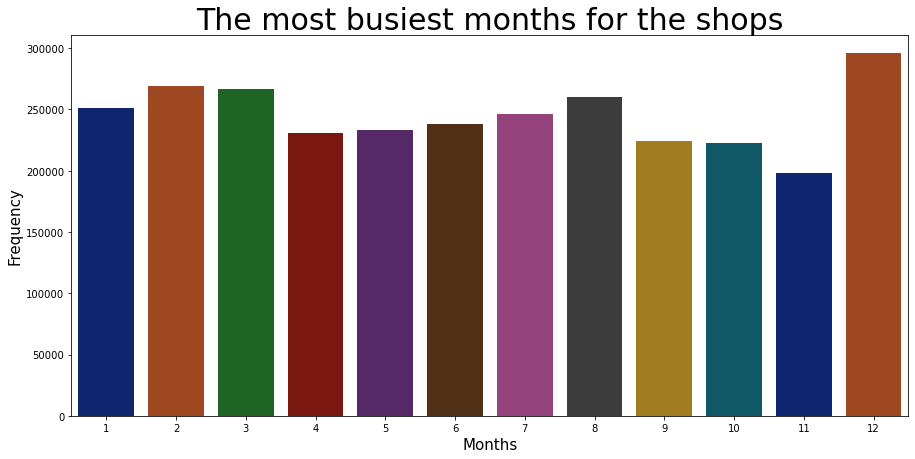

In [22]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(train['month'], palette = 'dark')
plt.title('The most busiest months for the shops', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.show()

#### 상점에서 가장 바쁜 해 확인
* 2013년이 가장 바쁜 해이다.
* 2015년은 11,12월 데이터셋이 없어서 적게 나왔다.

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


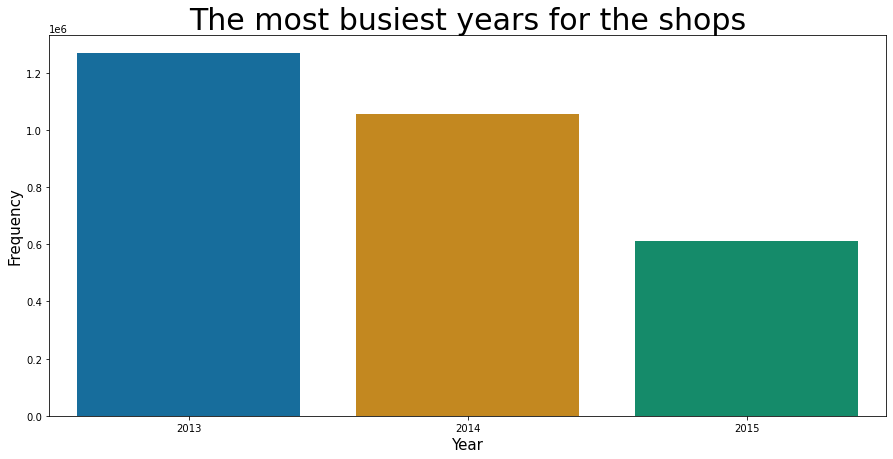

In [23]:
# checking which years are most busisiest for the shops

plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(train['year'], palette = 'colorblind')
plt.title('The most busiest years for the shops', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.show()

#### train 항목 확인

In [24]:
# checking the columns of the train data

train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'week'],
      dtype='object')

### Step 5-3. train_dataset의 물품가격과 물품 판매 수를 곱하여 얻은 수익 항목을 dataset에 추가.

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


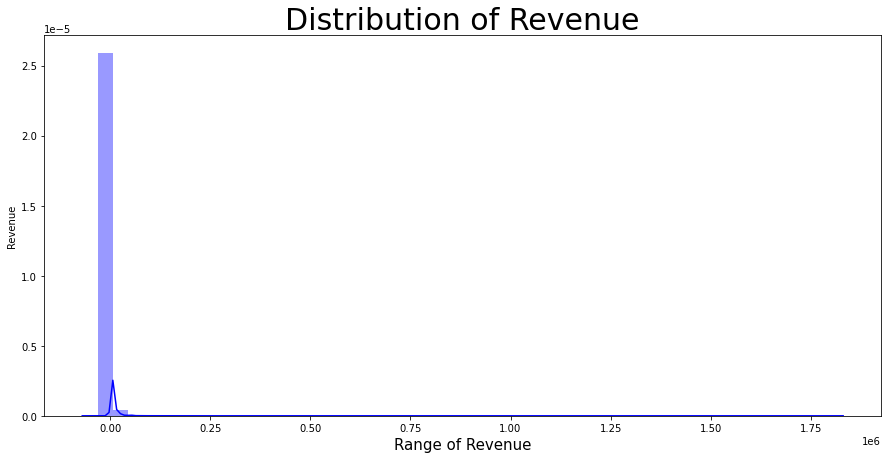

In [25]:
# feature engineering

train['revenue'] = train['item_price'] * train['item_cnt_day']

sns.distplot(train['revenue'], color = 'blue')
plt.title('Distribution of Revenue', fontsize = 30)
plt.xlabel('Range of Revenue', fontsize = 15)
plt.ylabel('Revenue')
plt.show()

In [26]:
train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
day                       object
month                      int64
year                       int64
week                       int64
revenue                  float64
dtype: object

#### 2013년 1월 ~ 2015년 10월에서 1일 ~ 31일 일별 판매 수익 총 합 확인
* 29일에 가장 큰 판매 수익을 확인할 수 있다.

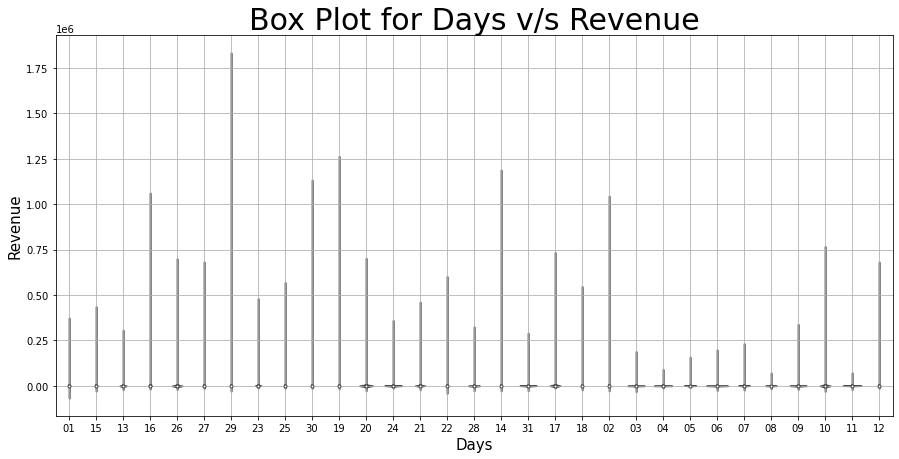

In [27]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.violinplot(x = train['day'], y = train['revenue'])
plt.title('Box Plot for Days v/s Revenue', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.grid(True)
plt.show()

#### 2013년 1월 ~ 2015년 10월에서 월별 판매 수익 분포 확인
* 판매량은 12월이 많았지만 판매수익은 11월이 더 큰 것을 확인할 수 있다. (연말 특수로 인한 효과로 생각됨)

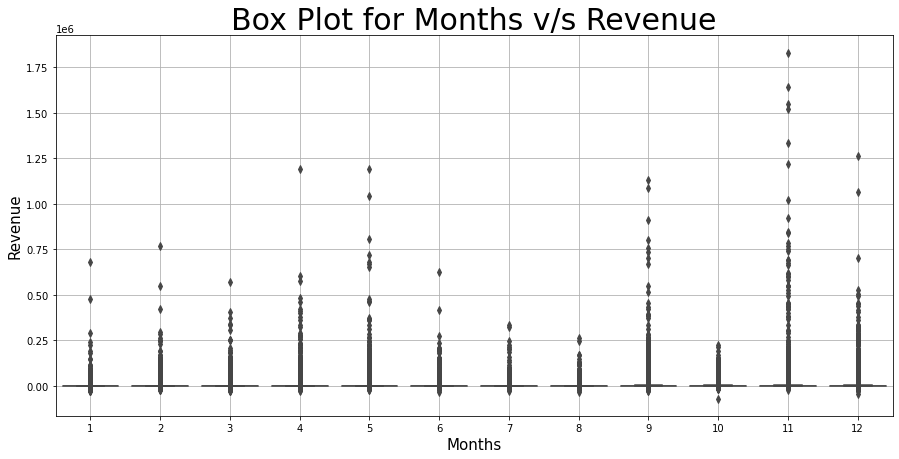

In [28]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.boxplot(x = train['month'], y = train['revenue'])
plt.title('Box Plot for Months v/s Revenue', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.grid(True)
plt.show()

#### 2013년, 2014년, 2015년 연 수익 확인
* 2013년 연 수익이 가장 큰 것을 확인할 수 있다.

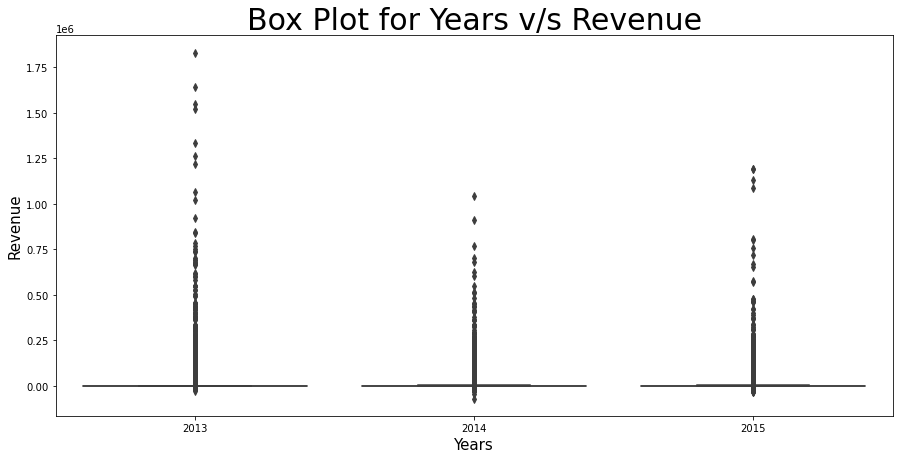

In [29]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.boxplot(x = train['year'], y = train['revenue'])
plt.title('Box Plot for Years v/s Revenue', fontsize = 30)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.show()

## Step 6. EDA 

<AxesSubplot:xlabel='item_price'>

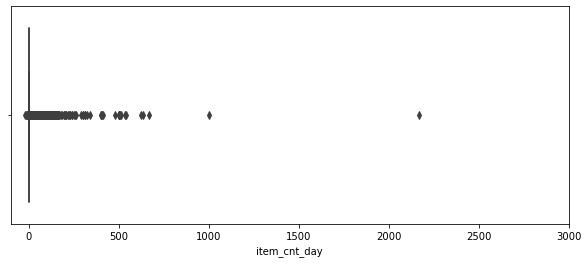

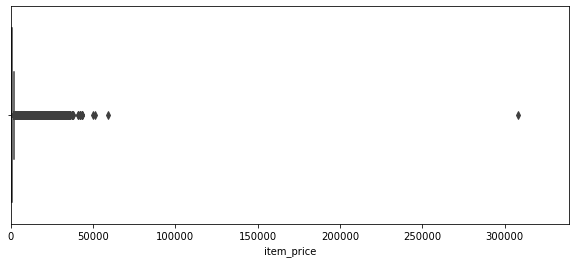

In [30]:
# Outliers (특이값) 확인하기
# remove items with price > 1000000 and sales > 1001
# 즉, 판매가 > 100000(위에선 백만인데 [29]코드를 보면 십만임)인 물건 제거, 판매량 > 1001인 물건 제거
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000) # x축 범위 설정 -> 데이터 파일을 확인하면 품목별 일일판매량이 최대 2500을 넘지 않으므로 여유있게 3000으로 설정
sns.boxplot(x=train.item_cnt_day) # 판매량 1002이상인(1002보다 크거나 같음) 물건이 두 개? 한 개? 있음 (x축 1000근처 2300근처)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1) # x축의 범위 설정 -> 판매최저가부터 판매최고가+alpha
# (*1.1은 최고가가 그래프 경계 안쪽에 오도록 설정해준 것), 판매최고가가 320000 근처이므로 여기에서 제거되는 품목은 없을 것임
sns.boxplot(x=train.item_price)

In [31]:
# remove outliers (특이값 제거)
train = train[train.item_price<100000] # 위에서 판매가가 십만보다 큰 항목 제거하므로 <100000인 데이터들만 추림
train = train[train.item_cnt_day<1001] # 위에서 일일판매량이 1001보다 큰 항목 제거하므로 <1001인 데이터들만 추림

In [32]:
# there is one item with price below 0, fill it with median
# 데이터 csv 파일을 확인해 보면, 한 품목의 가격이 음수인데 그 값을 median(중앙값)으로 채움
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,revenue
484683,2013-05-15,4,32,2973,-1.0,1.0,15,5,2013,20,-1.0


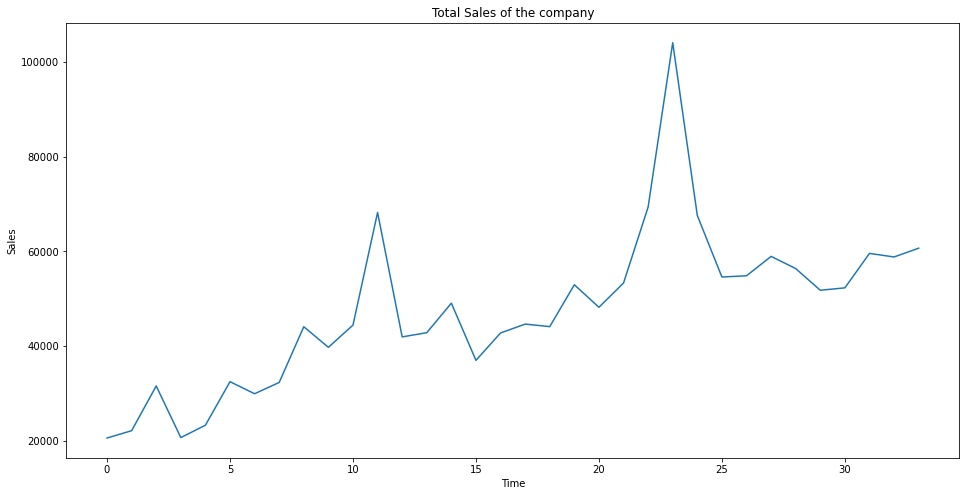

In [33]:
test_shops = test.shop_id.unique() # 평가데이터의 shop_id 유일값 찾기
train = train[train.shop_id.isin(test_shops)] # isin() 메소드를 이용한 인덱싱,
    # series나 dataframe 안의 요소가 메소드에 입력된 데이터를 가지고 있는지 판별(True/ False로 반환)
    # 학습데이터의 shop_id가 test_shops(즉, 평가데이터의 샵아이디)를 가지고 있는지 확인
    
test_items = test.item_id.unique() # 평가데이터의 item_id 유일값 찾기
train = train[train.item_id.isin(test_items)]
    # 학습데이터의 item_id가 test_items(즉, 평가데이터의 품목아이디)를 가지고 있는지 확인

# groupby : 같은 값을 하나로 묶어 통계 또는 집계 결과를 얻기 위해 사용하는 것
ts=train.groupby(["date_block_num"])["item_cnt_day"].sum() # 날짜에 순서를 매긴 date_block_num 값별로, 품목별 일일판매량 합산
ts.astype('float') # 실수형으로 바꿔주기 -> 안 맞으면 오류 발생 가능
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company') # 그래프 제목 (회사의 총판매량)
plt.xlabel('Time') # 그래프 x축 라벨 (시간)
plt.ylabel('Sales') # 그래프 y축 라벨 (판매량)
plt.plot(ts);

/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


<Figure size 1152x864 with 0 Axes>

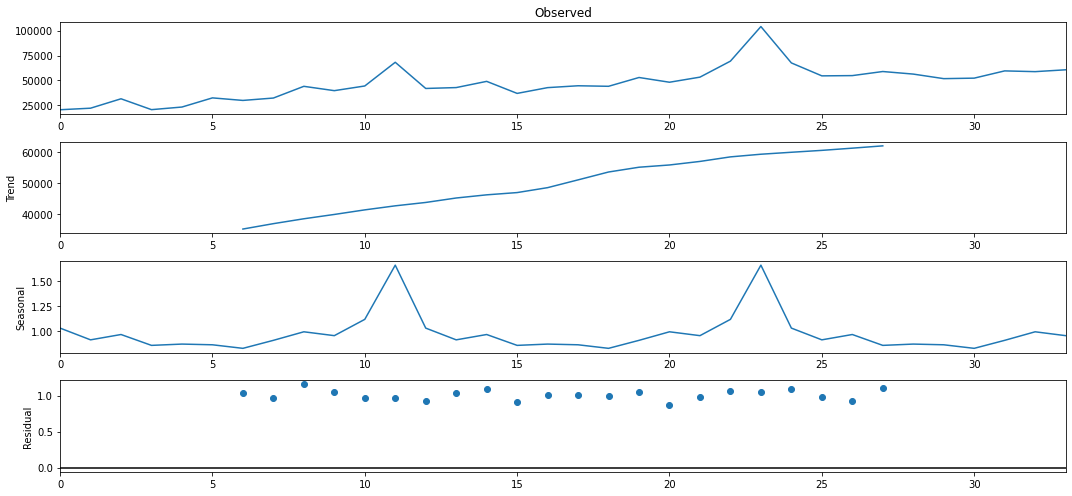

In [34]:
# multiplicative
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 분해 모듈

# 시계열 분해를 통해 시계열 자료를 추세(순환)(Trend), 계절성(Seasonality), 잔차(Residual)로 분해
# 추세(순환)(Trend) : 장/중기 변동 요인,
# 계절성(Seasonality) : 1년 주기,
# 잔차(Residual) : 표본집단에서 얻은 회귀식으로부터 "예측값-실제관측값" 계산 (모집단의 경우, '오차'라고 함)
# 모델 = 가법(add) 모형, 승법(mult) 모형
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative") # 여기선 승법 모형 이용
plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### Step 6-1. 데이터 merge, drop
* 일년원일 묶여있는 date 항목을 일,년,월,주,일로 분리
* items_dataset에서 item_id와 item_category_id 항목을 pandas.merge() 함수로 기존 train_dataset에 병합
* pandas.drop() 함수로 item_name 항목삭제

In [35]:
print(train.shape)

train['date'] = pd.to_datetime(train.date, format = '%d.%m.%Y')
train['day'] = train.date.dt.day
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['weekday'] = train.date.dt.dayofweek

train = train.merge(items, how = 'inner')
train.drop(['item_name'], inplace = True, axis = 1)
train['revenue'] = train['item_price'] * train['item_cnt_day']

print(train.shape)
train.head()

(1224438, 11)
(1224438, 13)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,revenue,weekday,item_category_id
0,2013-02-01,0,59,22154,999.0,1.0,1,2,2013,5,999.0,4,37
1,2013-01-23,0,24,22154,999.0,1.0,23,1,2013,4,999.0,2,37
2,2013-02-01,0,25,22154,999.0,1.0,1,2,2013,5,999.0,4,37
3,2013-03-01,0,25,22154,999.0,1.0,1,3,2013,9,999.0,4,37
4,2013-01-20,0,25,22154,999.0,1.0,20,1,2013,3,999.0,6,37


### Step 6-2. 물품가격 음수 값을 중앙값으로 초기화
* 물품가격은 항상 0 이상이여야 하는데 음수로된 이상치들은 중앙값으로 초기화 해준다.
* 중앙값은 계산은 pandas.median() 함수를 이용하였다.
* pandas.median() 함수는 요청 된 축에 대한 값의 중앙값을 반환한다.

In [36]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [37]:
# several shsops are duplicate, fix the train and test set
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Step 6-3. 가게이름, 카테고리, 물품명 전처리
* 각 shop_name은 도시 이름으로 시작한다.
* 각 범주에는 이름에 유형과 하위 유형이 포함된다.
* 각 항목에 모두 숫자만 남기기 위해 LabelEncoder() 라이브러리를 사용한다.

#### shops
* shop_name 항목에서 Сергиев Посад 띄어쓰기 되어있는 이름을 СергиевПосад로 붙이기
* shop_name 항목에서 띄어쓰기로 구분하여 list.split() 함수를 써서 분리. 가장앞에 단어가 도시명 이기 때문에 도시명 항목을 추가.
* !Якутск 도시명은 Якутск 도시명으로 초기화
* LabelEncoder() 라이브러리를 사용하여 도시명을 숫자화 시켜 city_code 항목을 만듦
* shops에서 city_code 항목과 shop_id 항목만 남김 

#### cats (=categorys)
* item_category_name 항목에서 '-'로 구문하여 list.split() 함수를 써서 분리. 그 후에 split 항목에 저장
* split 항목에서 가장 앞에 부분을 공백 삭제 후 type 항목으로 저장
* LabelEncoder() 라이브러리를 사용하여 물품 type을 숫자화 시켜 type_code 항목을 만듦
* split 항목에서 2번째 부분을 공백 삭제후 nan 값이 아닌 값만 subtype 항목에 저장
* LabelEncoder() 라이브러리를 사용하여 subtype을 숫자화 시켜 subtype_code 항목을 만듦

#### items 
* items 에서 item_name 삭제

###### Shops/Cats/Items preprocessing
- Each shop_name starts with the city name.
- Each category contains type and subtype in its name.

In [38]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [39]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(384, 5100, 214200)

In [40]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print(time.time() - ts,  " 초 경과 !")

3.3934261798858643  초 경과 !


In [41]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [42]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
print(time.time() - ts,  " 초 경과 !")

0.9713084697723389  초 경과 !


In [43]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [44]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
print(time.time() - ts,  " 초 경과 !")

0.020755529403686523  초 경과 !


In [45]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
print(time.time() - ts,  " 초 경과 !")

0.7118611335754395  초 경과 !


In [46]:
# Traget lag feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [47]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
print(time.time() - ts,  " 초 경과 !")

5.378355026245117  초 경과 !


In [48]:
# mean encoded features
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

1.6561479568481445  초 경과 !


In [49]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

6.3517115116119385  초 경과 !


In [50]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

6.166924715042114  초 경과 !


In [51]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
print(time.time() - ts,  " 초 경과 !")

1.9830310344696045  초 경과 !


In [52]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

1.9418821334838867  초 경과 !


In [53]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.228750228881836  초 경과 !


In [54]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.387659788131714  초 경과 !


In [55]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.212594985961914  초 경과 !


In [56]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

3.3362419605255127  초 경과 !


In [57]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.3907060623168945  초 경과 !


In [58]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

2.424844264984131  초 경과 !


Trend Features

In [62]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

print(time.time() - ts,  " 초 경과 !")

48.61555027961731  초 경과 !


In [63]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
print(time.time() - ts,  " 초 경과 !")

3.6096253395080566  초 경과 !


In [64]:
#special features
matrix['month'] = matrix['date_block_num'] % 12

In [65]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [66]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
print(time.time() - ts,  " 초 경과 !")

290.63999032974243  초 경과 !


In [67]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
print(time.time() - ts,  " 초 경과 !")

194.74165987968445  초 경과 !


In [68]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
print(time.time() - ts,  " 초 경과 !")

0.24555110931396484  초 경과 !


In [69]:
# final preparations
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
print(time.time() - ts,  " 초 경과 !")

0.23124003410339355  초 경과 !


In [70]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
print(time.time() - ts,  " 초 경과 !")

0.45273518562316895  초 경과 !


In [71]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'item_a

In [72]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2439209 entries, 506809 to 2946017
Data columns (total 43 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_item_

In [73]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
#del train
# leave test for submission
gc.collect();

## Step7. 학습 모델

## Model1. XGBoost

* 속도와 성능 향상시킨 gradient boosted decision trees의 구현 모델  
  
##### n_estimators  
* 의사 결정 트리의 수 (100~500), 대부분의 경우 특정값(100이나 200정도)을 넘어서는 트리를 추가해도 성능 향상 안 됨  
* 이유 : 부스트 된 트리 모델이 구성되는 방식으로, 각각의 새 트리가 순차적으로 이전 트리 시퀀스에서 발생한 오류를 모델링하고 수정하려고 시도하기 때문  
* 빠르게 모델은 수익이 감소하는 지점에 도달  
* default = 100 (주로 50부터 50단위로 확인/비교) : 논문에서 권장하는 값  
  
#####  max_depth  
* 의사 결정 트리의 크기 (레이어 수, 깊이)  
* 얕은 트리는 문제의 세부 사항을 거의 포착하지 않고 일반적으로 약한 학습자라고 불리기 때문에 성능이 떨어질 것으로 예상  
* 더 깊은 트리는 일반적으로 문제의 너무 많은 세부 정보를 캡처하고 훈련 데이터셋을 과적 합하여 새 데이터에 대하여 좋은 예측을 할 수 있는 능력을 제한  
* default = 3 (정수) : 논문에서 권장하는 값  
* 예) 1, 3, 5, 7, 9, ... 이런 식으로 확인  
* range: [0,∞]  
  
#####  min_child_weight  
* child에게 필요한 instance weight(= hessian)의 최소 합계  
* 트리 분할 단계에서 instance weight의 합이 min_child_weight보다 작은 leaf node가 생성되면 building process에서 더 이상의 분할을 하지 않음  
* 선형 회귀 작업에서 이는 단순히 각 노드에 있어야 하는 최소 인스턴스 수에 해당  
* 이 값이 클수록 알고리즘이 더 conservative
* range: [0,∞]  
  
#####  colsample_bytree  
* column들의 서브샘플링에 대한 파라미터  
* 각 트리를 구성 할 때 열(column)의 하위 표본 비율  
* 서브 샘플링은 구성된 모든 트리에 대해 한 번 발생  
* default = 1  
* range: (0,1]  
  
##### subsample = 1 (default)  
* 훈련 인스턴스의 서브 샘플 비율  
* 예) 0.5 설정 시, XGBoost가 트리의 가지를 확장하기 전에 훈련데이터의 반을 무작위로 추출하여 과적합 방지  
* 서브 샘플링은 모든 부스팅 반복에서 한 번만 수행  
* range: (0,1]  
  
* subsample은 data자체를 샘플링하는 것이고 colsample_* 파라미터는 feature를 샘플링하는 것   
* colsample_* 파라미터는 feature가 너무 많거나 소수의 feature에 지나치게 의존적일 때 사용하면 좋음.  
  
##### Eta [default=0.3, alias: `learning_rate`]  
* Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and `eta` shrinks the feature weights to make the boosting process more conservative  
* range: [0,1]  
  
##### XGBoost 에서 지원하는 평가 지표들 (이 외에도 가능)
* rmse : 평균 제곱근 오차, root mean squared error  
* mae : mean absolute error  
* logloss : binary logarithmic loss  
* mlogloss : multi-class log loss (cross entropy)
* error : 분류 오류, classification error
* auc : ROC 곡선 아래의 영역, area under ROC curve  
  
##### XGBoost 모델 피팅
* eval_metric 인수 에 x, y 쌍의 배열 제공  
* 테스트셋 외에도 학습데이터셋을 제공할 수도 있고, 그러면 학습 중에 학습/테스트셋 각각에서 모델이 얼마나 잘 수행되고 있는지 확인 가능  
* 각 평가 집합에 대한 모델의 성능이 저장되고 `model.evals_result()` 함수를 호출하여 학습 후 모델에서 사용 가능
* 이렇게 하면 evaluation 데이터셋의 dictionary 반환  
* `validation_0` 과 `validation_1` 각각은 `fit()` 호출에서 데이터셋이 eval_set 인수에 제공하는 순서에 해당
* 첫 번째 데이터셋 및 오류 측정 항목과 같은 특정 결과 배열은 `results['validation_0']['error']`으로 액세스  
* `early_stopping_rounds` : 개선이 관찰되지 않는 Epoch 수의 창을 지정하여 이 값만큼 횟수를 반복 후 조기 중지 지원  
* 여러 평가 데이터셋이나 여러 평가 메트릭이 제공되는 경우 조기 중지는 목록의 마지막 항목에 사용

In [74]:
import numpy as np
import pandas as pd
import time
import sys
import gc
import pickle

data = pd.read_pickle('data.pkl')

In [75]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [76]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [77]:
del data
gc.collect();

In [78]:
#xgboost 모델 학습 
import time
import xgboost as xgb
from xgboost import XGBRegressor

ts = time.time()

# model = XGBRegressor(
#     max_depth=8,
#     n_estimators=1000,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.3,    
#     seed=20)

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=400, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    sampling_method = 'uniform',
    eta=0.3,    
    seed=20)

clf = model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

print(time.time() - ts,  " 초 경과 !")

[0]	validation_0-rmse:1.37078	validation_1-rmse:1.09212
[1]	validation_0-rmse:1.24280	validation_1-rmse:1.01345
[2]	validation_0-rmse:1.16932	validation_1-rmse:0.97000
[3]	validation_0-rmse:1.12604	validation_1-rmse:0.95439
[4]	validation_0-rmse:1.09979	validation_1-rmse:0.94152
[5]	validation_0-rmse:1.07949	validation_1-rmse:0.94319
[6]	validation_0-rmse:1.06505	validation_1-rmse:0.93896
[7]	validation_0-rmse:1.05713	validation_1-rmse:0.93781
[8]	validation_0-rmse:1.05062	validation_1-rmse:0.93872
[9]	validation_0-rmse:1.04602	validation_1-rmse:0.94115
[10]	validation_0-rmse:1.04326	validation_1-rmse:0.94096
[11]	validation_0-rmse:1.03837	validation_1-rmse:0.94111
[12]	validation_0-rmse:1.03306	validation_1-rmse:0.94068
[13]	validation_0-rmse:1.03188	validation_1-rmse:0.94085
[14]	validation_0-rmse:1.02926	validation_1-rmse:0.94026
[15]	validation_0-rmse:1.02725	validation_1-rmse:0.94114
[16]	validation_0-rmse:1.02612	validation_1-rmse:0.94122
29.011617183685303  초 경과 !


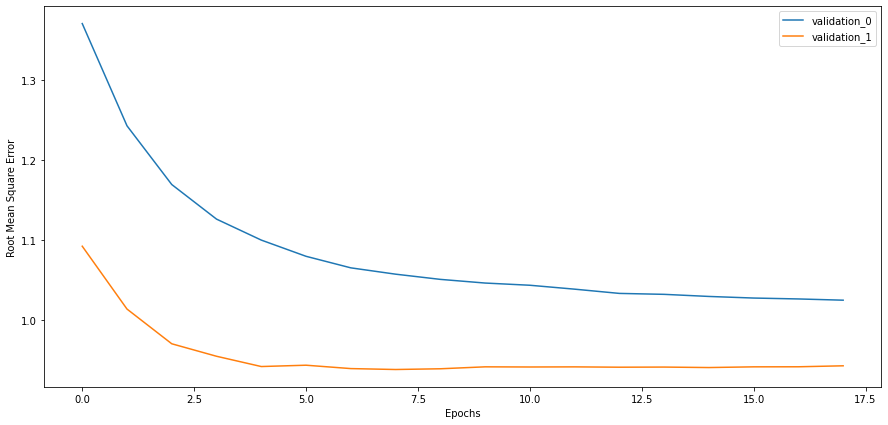

<Figure size 1080x504 with 0 Axes>

In [79]:
#xgboost 모델 학습 결과 그래프로 확인
#clf.evals_result()
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])

plt.plot(results['validation_0']['rmse'], label='validation_0')
plt.plot(results['validation_1']['rmse'], label='validation_1')
plt.xlabel("Epochs")
plt.ylabel("Root Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Validations RMSE Progression.png")

In [80]:
#xgboost 모델 학습 예측 
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

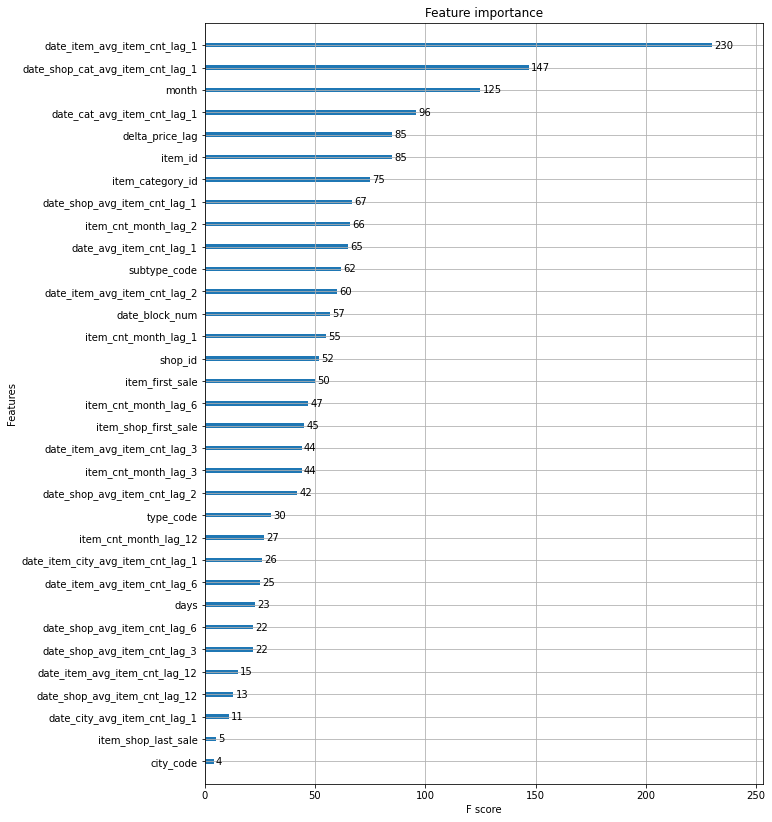

In [81]:
plot_features(model, (10,14))

## Model2. LSTM

* LSTM (Long Short-Term Memory) 네트워크는 시계열 예측에 적용  
* 유형별 시계열 예측 문제에 사용 가능한 다양한 타입 존재

### 유형별 LSTM 모델의 종류  
##### Univariate LSTM Models (일변수 모델)
* 일련의 단일 관측치로 구성된 문제, 과거 관측치로부터 학습하여 시퀀스의 다음 값 예측
* `model.compile(optimizer='adam', loss='mse')`
  
__일변수 모델 종류__
* Vanilla LSTM : 단일 히든 레이어, 예측에 사용되는 출력 레이어  
* Stacked LSTM (스택형) : 여러 개의 히든 스택형 레이어를 다른 스택형 레이어에 쌓을 수 있음  
* Bidirectional LSTM (양방향) : 입력 시퀀스를 앞뒤로 학습하고 두 해석을 상호 연결, 일변수 시계열 예측을 위해 첫 번째 히든레이어를 양방향 레이어로 감싸는 형식  
* CNN LSTM (Convolution neural network) : 2차원 이미지 데이터,일변수 시계열 데이터처럼 1차원 시퀀스 데이터에서의 feature를 자동으로 추출하여 학습하는 데 효과적 
* ConvLSTM : CNN-LSTM 과 관련된 유형, 입력된 컨볼루션 판독값이 각 LSTM unit에 직접 내장, 2차원 spatial-temporal data를 읽기 위해 개발됐지만 일변수 시계열 예측과 함께 사용하도록 조정 가능  
  
##### Multivariate LSTM Models (다변수 모델)  
* 다변수 시계열 데이터 : 각 시간별로 둘 이상의 관측치가 있는 데이터를 의미  
  
__다변수 모델 종류__  
* Multiple Input Series (다중 입력 시리즈)  
* Multiple Parallel Series (다중 병렬 시리즈)  
  
##### Multi-Step LSTM Models (다단계 모델)  
* 다단계 시계열 예측 : 미래의 여러 시간 단계를 예측해야 하는 문제. 특히, 예측 기간 또는 구간이 2-time step 이상인 문제  
  
__다단계 모델 종류__  
* Vector Output Model (벡터 출력 모델)    
* Encoder-Decoder Model (인코더-디코더 모델)  
  
##### Multivariate Multi-Step LSTM Models (다변수 다단계 모델)
* 위의 다양한 문제들에 제시된 유형들을 혼합  
  
__다변수 다단계 모델 종류__  
* Multiple Input Multi-Step Output (다중 입력 다단계 출력)  
* Multiple Parallel Input and Multi-Step Output (다중 병렬입력 및 다중단계 출력)

In [82]:
print(X_train.values.shape)

print(Y_train.values.shape)

print(X_valid.values.shape)

print(Y_valid.values.shape)

print(X_test.shape)

(2058899, 34)
(2058899,)
(166110, 34)
(166110,)
(214200, 34)


In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import gc

In [84]:
X_train=X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_valid=X_valid.values.reshape((X_valid.shape[0],X_valid.shape[1],1))

Y_train=Y_train.values.reshape((Y_train.shape[0],1))
Y_valid=Y_valid.values.reshape((Y_valid.shape[0],1))

X_test=X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))

In [85]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 34, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 34, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
______________________________________________________

Epoch 1/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.6432 - mse: 1.6432 - val_loss: 0.9992 - val_mse: 0.9992
Epoch 2/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.4995 - mse: 1.4995 - val_loss: 1.0044 - val_mse: 1.0044
Epoch 3/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.4689 - mse: 1.4689 - val_loss: 1.0043 - val_mse: 1.0043
Epoch 4/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.4388 - mse: 1.4388 - val_loss: 0.9661 - val_mse: 0.9661
Epoch 5/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.4206 - mse: 1.4206 - val_loss: 1.0210 - val_mse: 1.0210
Epoch 6/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.4122 - mse: 1.4122 - val_loss: 0.9778 - val_mse: 0.9778
Epoch 7/10
1006/1006 [==============================] - 8s 8ms/step - loss: 1.4089 - mse: 1.4089 - val_loss: 0.9606 - val_mse: 0.9606
Epoch 8/10
1006/1006 [==============================] - 8s 8ms

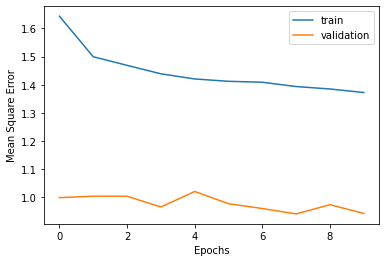

<Figure size 432x288 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

LSTM_PARAM = {"batch_size":2048,
              "verbose":1,
              "epochs":10}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=7,mode='auto')]
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),callbacks=callbacks_list, **LSTM_PARAM)
pred = model_lstm.predict(X_test)

#plot_features(model_lstm, (10,14))

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression.png")

In [87]:
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('lstm_submission.csv',index_label='ID')

## Model3. LGBM

In [88]:
import os 
import numpy as np
import pandas as pd

PATH = os.getenv('HOME')+'/aiffel/kaggle-predict-future-sales-master/data/'
sample_sub = pd.read_csv(PATH+'sample_submission.csv')

#items = pd.read_csv(PATH+'items.csv')
#shops = pd.read_csv(PATH+'shops.csv')
#cats = pd.read_csv(PATH+'item_categories.csv')
train = pd.read_csv(PATH+'sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv(PATH+'test.csv').set_index('ID')

# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
train.loc[:,'date'] = pd.to_datetime(train.date)

In [89]:
# converting the data into monthly sales data

# making a dataset with only monthly sales data
data = train.groupby([train['date'].apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()

# specifying the important attributes which we want to add to the data
data = data[['date','item_id','shop_id','item_cnt_day']]

# at last we can select the specific attributes from the dataset which are important 
data = data.pivot_table(index=['item_id','shop_id'], columns = 'date', values = 'item_cnt_day', fill_value = 0).reset_index()

# looking at the newly prepared datset
data.shape

(424124, 38)

In [90]:
# let's merge the monthly sales data prepared to the test data set

test = pd.merge(test, data, on = ['item_id', 'shop_id'], how = 'left')

# filling the empty values found in the dataset
test.fillna(0, inplace = True)

# checking the dataset
test.head()

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# now let's create the actual training data
x_train = test.drop(['2015-10', 'item_id', 'shop_id'], axis = 1)
y_train = test['2015-10']

# deleting the first column so that it can predict the future sales data
x_test = test.drop(['2013-01', 'item_id', 'shop_id'], axis = 1)

# checking the shapes of the datasets
print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_train.shape)

Shape of x_train : (214200, 35)
Shape of x_test : (214200, 35)
Shape of y_test : (214200,)


In [92]:
# let's check the x_train dataset

x_train.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-11,2015-12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# let's check the x_test data

x_test.head()

,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# splitting the data into train and valid dataset

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

# checking the shapes
print("Shape of x_train :", x_train.shape)
print("Shape of x_valid :", x_valid.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_valid :", y_valid.shape)

Shape of x_train : (171360, 35)
Shape of x_valid : (42840, 35)
Shape of y_train : (171360,)
Shape of y_valid : (42840,)


In [95]:
# MODELING
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

estimator = lgb.LGBMRegressor()

# get possible parameters
estimator.get_params().keys()


from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
model_lgb = LGBMRegressor( n_estimators=200,
                           learning_rate=0.03,
                           num_leaves=32,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           max_depth=8,
                           reg_alpha=0.04,
                           reg_lambda=0.073,
                           min_split_gain=0.0222415,
                           min_child_weight=40)
gbm = model_lgb.fit(x_train, y_train)

y_pred_lgb = model_lgb.predict(x_test)

#LGBM 모델 학습 결과 그래프로 확인
print('Feature importances:', list(gbm.feature_importances_))

#print('Plot metrics during training...')
# ax = model_lgb.plot_metric(evals_result, metric='2')
# plt.show()

print('Feature names',gbm.feature_name_)# this is where went wrong
#gbm.evals_result()
# results = clf.evals_result()
# epochs = len(results['validation_0']['rmse'])

# plt.plot(results['validation_0']['rmse'], label='validation_0')
# plt.plot(results['validation_1']['rmse'], label='validation_1')
# plt.xlabel("Epochs")
# plt.ylabel("Root Mean Square Error")
# plt.legend()
# plt.show()
# plt.savefig("Validations RMSE Progression.png")

Feature importances: [0, 92, 48, 3, 3, 0, 4, 1, 71, 3, 3, 5, 14, 12, 9, 10, 4, 13, 6, 18, 28, 85, 35, 229, 276, 116, 149, 323, 247, 156, 249, 255, 347, 247, 138]
Feature names ['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-11', '2015-12']


In [96]:
# Get the test set predictions and clip values to the specified range
y_pred_lgb = model_lgb.predict(x_test).clip(0., 20.)

# Create the submission file and submit
preds = pd.DataFrame(y_pred_lgb, columns=['item_cnt_month'])
preds.to_csv('lgbm_submission.csv',index_label='ID')

# ♣ 프로젝트 수행결과 

## 1. 모델 고찰
**Kaggle  Predict Future Sales 프로젝트 결과**  

 **`XGBoost_Model_6 하이퍼 파라메터 수정 (최종): score = 0.91261`**   
` XGBoost_Model_1 : score = 0.93851   
 LSTM_Model_2 : score = 0.95702  
 LGBM_Model_3 : score = 1.08169  
 XGBoost_Model_4 : score = 0.94020 (1번 모델의 하이퍼파라미터들을 디폴트값으로 변경 적용)`   

위의 세 가지 모델들 중 XGBoost 모델의 예측이 가장 좋았는데, 특히 1번 모델에서 사용한 하이퍼파라미터 값들은 디폴트 값이 아니어서 이 모델을 처음 적용한 사람이 성능이 좋은 파라미터를 찾은 것으로 추측된다. 랜덤으로 적용한 것은 아닐 것으로 예상하여 여러 하이퍼파라미터들이 무엇을 조절하는 값인지를 공부했는데, 시간적 여유가 충분하다면 좀 더 성능을 향상시킬 수 있을만한 파라미터를 찾을 수 있지 않을까 생각한다.

### * XGBoost_Model_6 하이퍼 파라메타 수정 결과 (최종)
#### (min_child_weight=400, sampling_method = 'uniform' 추가) 
![png](img/Xgbooster_Model_Hyperparameter_01.png)
![png](img/Xgbooster_Model_Hyperparameter_02.png)
![png](img/Xgbooster_Model_Hyperparameter_03.png)

### * XGBoost_Model_1 결과
![png](img/XGBoost_Model_01.png)
![png](img/XGBoost_Model_02.png)
![png](img/XGBoost_Model_03.png)

### * LSTM_Model_2 결과
![png](img/LSTM_Model_01.png)
![png](img/LSTM_Model_02.png)
![png](img/LSTM_Model_03.png)

### * LGBM_Model_3 결과
![png](img/LGBM_Model_01.png)
![png](img/LGBM_Model_02.png)
![png](img/LGBM_Model_03.png)


## 2. 프로젝트 협업 과정
● 프로젝트 요구 사항 분석  
● 데이터 형태 및 경향 분석  
● 시계열 분석 아이펠 노트 학습 (Node 17)  
● 업무 분담  
● 회의록 작성 및 노션 팀페이지 작성  
● 샘플 코드 서치  
● 시각화 자료 탐색  
● 케글 ID만들고 팀병합  
● 케글 submission 예행연습  
● 샘플 학습 결과 케글 Score 확인  
● 이상치, 특이치, 전처리 과정  
● 학습 모델 분석 (XGBoost, LSTM, LGBM, TS_LSTM)  
● 하이퍼파라메터 조정  
● 코드 분석 및 주석 달기  
● 코드 수정 및 통합   
● 학습결과 케글 submit & score 확인/캡춰  
● 프로젝트 수행 평가 및 고찰   
● 프로젝트 결과 제출  


## 3.  프로젝트 고찰

## * 임진선
### ▣ 어려웠던 점 
처음으로 협업을 통해 프로젝트를 진행해야 한다는 중압감이 컸고, 정해진 시간 안에 수행해야 하는데 프로젝트을 이해하고 수행하는에 시간적으로나 체력적으로 한계를 느겼다. 
### ▣ 해결 방법 
팀원과의 여러 차례 회의와 소통 과정을 통해서 저마다의 강점과 약점을 파악하고 이를 조율해 가면서 업무 분담을 하였고, 코드 Base1 ~ 5까지 진행하면서 서로 분담한 부분을 취합하고 통합하면서 시간과 노력을 절약할 수 있었다. 

### ▣ 과제를 통해 얻은 점 
프로젝트를 수행하기 전에 가장 비슷한 Node 17을 함께 처음부터 학습하면서, 팀원의 성향과 강점을 알 수 있었고 많은 시간 회의와 의견 교환으로 이해되지 않거나 오류가 있는 부분을 서로 보완하면서 프로젝트를 진행할 수 있었다. 
이런 과정을 통해서 협업에 있어서 필요한 부분이 어떤 것인지를 알 수 있었다.

### ▣ 소감
시간적 여유가 좀더 있었다면 좀더 체계적으로 프로젝트에 대해 공부해 볼 수 있었을텐데라는 아쉬움이 크게 남는다. 

## 양윤정
### ▣ 어려웠던 점 
* 양윤정 : 데이터 파악부터 전처리 과정 및 모델에 대한 공부, 조원들과의 지향점을 조율하는 것

### ▣ 해결 방법 
* 자주 만나서 오랜 시간 함께 작업하며 대화를 많이 함

### ▣ 과제를 통해 얻은 점 
* 공동작업 시, (아직 부족하지만) 의견 조율하는 방법을 배웠음

### ▣ 소감
* 살면서 이런 작업은 최소한으로 하고 싶다.


## 김상민
### ▣ 어려웠던 점 
코드분석이 제일 어려웠고, 시각화 과정에서 나타난 값이 어떤 값을 의미하는지 이해할 때 어려웠다.

### ▣ 해결 방법 
코드분석은 구글링으로 모르는 함수들을 검색하여 해결하고, 시각화 값들이 이해가 잘 안될 땐 csv 파일을 열어보거나 pandas.describe() 결과를 보고 이해하였다. astype()로 자료형을 안맞추어주면 오류가 날때가 있었는데 이를 해결하였다.

### ▣ 과제를 통해 얻은 점 
* pandas.describe()에서 제공하는 데이터 통계값을 읽는 방법을 잘 몰랐었는데 알게되었다. 2.169000e+03 라는 값이 있으면 2.169 * 10^3이라는 의미로 2169 였다. 시각화 툴과 그래프 보는 법을 좀 더 익혔다.

### ▣ 소감
* 같은 팀원인 윤정님과 진선님이 너무 잘하시고 팀웍이 좋아서 정말 스파르타식으로 해커톤에 참여한 것 같다. 거의 항상 마이크를 켜놓고 얘기를 하면서 해서 쉴틈이 없었다. 진선님의 리더쉽, 윤정님의 수학적 지식과 좋은 설명이 많은 도움이 되었다. 각자의 장단점이 잘 융합된 것 같아 좋았다.